In [315]:
import matplotlib.pyplot as plt 
import numpy as np 
from io import StringIO 
from Bio import Phylo 
import subprocess 
import gzip 
import pandas as pd
import itertools
from scipy.stats import gaussian_kde
from intervaltree import Interval, IntervalTree
from sklearn.cluster import DBSCAN
import plotly.graph_objs as go
import pysam

In [316]:
class Cell:
    def __init__(self, name, idx0_, idx1_, mut):
        self.name = name 
        self.idx0_ = idx0_ 
        self.idx1_ = idx1_ 
        self.mut = mut 



# Parse reference FASTA
refname = "/Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa"

def build_block_ref(refname, resolution):
    # ASSUMES RESOLUTION IS A MULTIPLE OF 60
    ref = []
    with open(refname, 'r') as f:
        for line in f:
            if not line.startswith(">"):
                ref.append(line.strip())

    # Each line ~60bp -> group resolution // 60 lines into single block
    step = resolution // 60
    ref_blocks = []
    for i in range(0, len(ref), step):
        block = "".join(ref[i:i+step])
        ref_blocks.append(block)

    # Optional: track index
    ref_idx = list(range(len(ref_blocks)))
    reflength = resolution * (len(ref_blocks) - 1) + len(ref_blocks[-1])

    return ref_blocks, reflength, len(ref_blocks)

samtools = "/Users/rfeld/Documents/Research/SPATIAL/spatial_24/DWGSIM/samtools/samtools"

def _match_to_mut(d):
    ARGS_LIST = ["allele", "region_len_", "region_loc_", "copynum"]

    a = {cell: {arg: None for arg in ARGS_LIST} for cell in d["cell_names"]}
    b = {cell: {arg: None for arg in ARGS_LIST} for cell in d["cell_names"]} 

    _a = d["assigned_mut_specs"]; _b = d["bounded_mut_specs"]

    # FILL IN ASSIGNED
    if d["assigned_mut_specs"] is None:
        pass
    # allow for global pass (ie. all copy numbers are insertions)
    elif len(set((d["assigned_mut_specs"].keys())).intersection(set(ARGS_LIST))) != 0:
        for key, val in _a.items():
            for cell in d["cell_names"]:
                a[cell][key] = val 
    # otherwise, specification is cellwise
    else:
        for cell, specs in _a.items():
            if specs is not None:
                for key, val in specs.items():
                    a[cell][key] = val 
    
    # FILL IN BOUNDED
    if d["bounded_mut_specs"] is None: 
        pass
    elif len(set((d["bounded_mut_specs"].keys())).intersection(set(ARGS_LIST))) != 0:
        for key, val in _b.items():
            for cell in d["cell_names"]:
                b[cell][key] = val 
    else:
        for cell, specs in _b.items():
            if specs is not None: 
                for key, val in specs.items():
                    b[cell][key] = val  
    

    d["assigned_mut_specs"] = a.copy()
    d["bounded_mut_specs"] = b.copy()

    return d

def _match_to_args(d):
    """ completes d to align style with full object 

    Parameters
    ----------
    d : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    # ---- FIRST ASSIGNMENT ----
    ARGS_LIST = ["refloc", "reflen", "reflen_", "ref",
                 "seqdir", "nwk_string", "resolution",
                 "assigned_mut_specs", "bounded_mut_specs",
                 "readdir", "tracksize_", 
                 "outerdist", "readlen", "readmode", "numreads",
                 "coverage", "mixture_props", "expdir", "mut_len_param", "total_reads",
                 "mixture_select", "num_in_mixture", "force_include_founder","signal_threshold",
                 "quality_exclusion", "stricter_insertions", "insert_max", "contig"]
    
    DEFAULTS = {"resolution": 600,
                "outerdist": 1500,
                "readlen": 300, 
                "tracksize_": 3,
                "refloc":"/Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21_00-01Mb.fa",
                "seqdir":"/Users/rfeld/Documents/Research/SPATIAL/output/experiments/misc_seq",
                "readdir":"/Users/rfeld/Documents/Research/SPATIAL/output/experiments/misc_read",
                "nwk_string": "(cell1:0.1)founder;",
                "readmode": 1,
                "mut_len_param":500,
                "total_reads":200000,
                "force_include_founder":1,
                "quality_exclusion": 45,
                "stricter_insertions": True,
                "insert_max": 800,
                "contig": "chr21_tiny"}
    # threshold 
    # force_include behavior: always excluded for -1, treated equally for 0, always included for 1.
    # CNASim default mutlen param?
    
    new_dict = {arg: None for arg in ARGS_LIST} 
    for key, value in DEFAULTS.items():
        new_dict[key] = value

    # write over the ones that we have
    for key, value in d.items():
        assert key in ARGS_LIST, f"Cannot find argument: '{key}'"
        new_dict[key] = value 

    # DERIVED QUANTITIES
    # recompute threshold if not provided
    if new_dict["signal_threshold"] is None:
        new_dict["signal_threshold"] = 2 * (new_dict["outerdist"] + new_dict["readlen"])

    ref, reflen, reflen_ = build_block_ref(new_dict["refloc"], new_dict["resolution"])
    new_dict["ref"] = ref; new_dict["reflen"] = reflen; new_dict["reflen_"] = reflen_
    new_dict['insert_max'] = new_dict['outerdist'] + 500

    # specification of total reads in d (not new_dict default) overwrites coverage, but 
    # if neither provided, preferentially take the default total_reads. 
    if "total_reads" in d.keys():
        new_dict["coverage"] = new_dict["total_reads"] * 2 * new_dict["readlen"] / new_dict["reflen"]
    elif "coverage" in d.keys():
        new_dict["total_reads"] = int(new_dict["coverage"] * new_dict["reflen"] / (2 * new_dict["readlen"]))
    else: 
        new_dict["coverage"] = new_dict["total_reads"] * 2 * new_dict["readlen"] / new_dict["reflen"]

    # overwrite tracksize with similar logic 
    if "tracksize_" not in d.keys():
        new_dict["tracksize_"] = 1 + (new_dict["outerdist"] + 2 * new_dict["readlen"]) // new_dict["resolution"]
    
    tree = Phylo.read(StringIO(new_dict["nwk_string"]), "newick")
    new_dict["cell_names"] = list(set([child.name for clade in tree.find_clades(order = "level") \
                                       for child in clade.clades]))

    new_dict = _match_to_mut(new_dict)

    # util - make directories 
    subprocess.call(["mkdir", "-p", new_dict["seqdir"]])
    subprocess.call(["mkdir", "-p", new_dict["readdir"]])

    return new_dict

def _build_d_experiment_level(shared, varying, exp_names):
    assert "expdir" in shared.keys(), "No top level directory indicated (`expdir`)"
    if len(exp_names) == 1:
        shared["seqdir"] = f"{shared['expdir']}/sequences"
        shared["readdir"] = f"{shared['expdir']}/reads"
        return {exp_names[0]: _match_to_args(shared)}
    else:
        ds = {name: shared.copy() for name in exp_names}
        for name in exp_names:
            ds[name]["seqdir"] = f"{shared['expdir']}/{name}/sequences"
            ds[name]["readdir"] = f"{shared['expdir']}/{name}/reads"

            for key, _ in varying.items():
                ds[name][key] = varying[key][name] 
    ds = {name: _match_to_args(ds[name]) for name in exp_names}

    return ds

def generate_random_mutation(a, b, idx0_, idx1_, d, seed = None):
    rng = np.random.default_rng(seed)
    # --- MANUAL ASSIGNMENT ---
    # allele 
    if a["allele"] is not None:
        allele = a["allele"]
    else:
        allele = rng.integers(0, 2)

    idx_ = idx0_ if allele == 0 else idx1_
    parent_len_ = len(idx_)

    # length 
    if a["region_len_"] is not None:
        assert a["region_len_"] < parent_len_, \
            "Logic Mismatch: mutation region longer than parent"
        region_len_ = a["region_len_"]
    elif b["region_len_"] is not None:
        assert b["region_len_"][0] < parent_len_, \
            "Logic Mismatch: mutation region longer than parent"
        lenmin_, lenmax_ = b["region_len_"][0], min(b["region_len_1"], parent_len_)
        region_len_ = -1
        while (region_len_ > lenmax_) | (region_len_ < lenmin_):
            region_len_ = max(min(round(rng.exponential(d["mut_len_param"])), 
                          parent_len_), 1)
    else:
        region_len_ = max(min(round(rng.exponential(d["mut_len_param"])), 
                          parent_len_), 1) 
    
    # location 
    if a["region_loc_"] is not None:
        assert a["region_loc_"] + region_len_ <= parent_len_, \
            "Logic Mismatch: mutation region too far right"
        region_loc_ = a["region_loc_"] 
    elif b["region_loc_"] is not None: 
        assert b["region_loc_"][0] + region_len_ <= parent_len_, \
            "Logic Mismatch: mutation region too fair right"
        region_loc_ = rng.integers(b["region_loc_"][0], 
                                        min(parent_len_, b["region_loc_"][1]) - region_len_ + 1)
    else:
        region_loc_ = rng.integers(parent_len_ - region_len_ + 1)
    
    # copies 
    if a["copynum"] is not None:
        copynum = a["copynum"] 
    elif b["copynum"] is not None: 
        # only deletions
        if b["copynum"][1] == 0:
            copynum = 0
        else:
            # generate geometric within boundary 
            copynum = max(min(b["copynum"][1], rng.geometric(0.5) + 1), b["copynum"][0])
            # if deletions are allowed, zero it out with probability 1/2
            if b["copynum"][0] == 0:
                copynum = copynum * rng.integers(0, 2) 
    else:
        copynum = (rng.geometric(0.5) + 1) * rng.integers(0,2) 
    # --- END MANUAL ASSIGNMENT ---

    new_idx_ = idx_[:region_loc_] + copynum * idx_[region_loc_: region_loc_ + region_len_] \
        + idx_[region_loc_ + region_len_:]
    
    # for tracking, store signal by mutation boundary
    # size dictated by resolution
    
    # for deletions, take outer as track
    if copynum == 0:
        # adjust for close to edges
        _leftmar = min(len(idx_[:region_loc_]), d["tracksize_"])
        _rightmar = min(len(idx_[region_loc_ + region_len_:]), d["tracksize_"])
        new_tr_ = (idx_[region_loc_ - _leftmar:region_loc_], 
                   idx_[region_loc_ + region_len_:region_loc_ + region_len_ + _rightmar], copynum)
    # for insertions, take inner
    else:
        # check tracksize issues
        if d["tracksize_"] > region_len_:
            new_tr_ = (idx_[region_loc_:region_loc_ + region_len_],
                       idx_[region_loc_:region_loc_ + region_len_],
                       copynum)
        else: 
            new_tr_ = (idx_[region_loc_ + region_len_ - d["tracksize_"]: region_loc_ + region_len_],
                       idx_[region_loc_: region_loc_ + d["tracksize_"]],
                       copynum)
            
    new_idx0_ = new_idx_ if allele == 0 else idx0_ 
    new_idx1_ = new_idx_ if allele == 1 else idx1_

    return new_idx0_, new_idx1_, {
        "copynum": copynum,
        "allele": allele,
        "region_loc_": region_loc_,
        "region_len_": region_len_,
        "tr_": new_tr_
    }




def mutated_tree(d:dict):
    """ generates complete mutations with logic #PHRASING

    behavior: if 

    Parameters
    ----------
    mut_specs : dict
        _description_

    Returns
    -------

    """

    # block index to mutate (mutate a reference index and then assign back)
    idx0_ = list(range(d["reflen_"]))
    idx1_ = list(range(d["reflen_"])) # have not implemented different starting alleles

    tree = Phylo.read(StringIO(d["nwk_string"]), "newick")
    tree.ladderize()
    parent_map = {child: clade for clade in tree.find_clades(order="level") for child in clade.clades}

    a = d["assigned_mut_specs"]
    b = d["bounded_mut_specs"]

    cells = {}

    for node in tree.find_clades(order="level"):
        if not node.name:
            continue 
        parent = parent_map.get(node)
        if parent is None:
            cells[node.name] = Cell(node.name, idx0_.copy(), idx1_.copy(), None)
            continue 
        idx0_ = cells[parent.name].idx0_.copy()
        idx1_ = cells[parent.name].idx1_.copy() 

        new_idx0_, new_idx1_, mut = generate_random_mutation(a[node.name], b[node.name], 
                                                             idx0_, idx1_, d)
        cells[node.name] = Cell(node.name, new_idx0_.copy(), new_idx1_.copy(), mut)
    
    return tree, parent_map, cells

def write_fasta(block_index, header, ref, fname, fpath):
    seq = [ref[i] for i in block_index]
    fasta_loc = f"{fpath}/{fname}.fa"
    with open(fasta_loc, "w") as f:
        f.write(f">{header}\n")
        for block in seq:
            for i in range(0, len(block), 60):
                f.write(block[i:i+60] + "\n")
    
    return fasta_loc

def _filter_reads(input_file, output_file, names_to_keep):
    with gzip.open(input_file, 'rt') as f_in, open(output_file, 'w') as f_out:
        while True:
            header = f_in.readline()
            seq = f_in.readline()
            plus = f_in.readline()
            qual = f_in.readline()
            if not header:
                break
            read_name = header.strip().split()[0].replace("/1", "").replace("/2", "")
            if read_name in names_to_keep:
                f_out.write(header + seq + plus + qual)

def _get_read_names(file_path, name):
    read_names = set()
    with gzip.open(file_path, 'rt') as f:
        while True:
            header = f.readline().strip()
            f.readline()  # seq
            f.readline()  # plus
            f.readline()  # qual
            if not header:
                break
            if header.startswith(f"@{name}"):  # Mapped reads
                read_name = header.split()[0].replace("/1", "").replace("/2", "")
                read_names.add(read_name)
    return read_names

def _compute_lr(mode):
    if mode == 0:
        pass
    elif mode == 1:
        def compute_lr(row):
            if row["strand"] == 1:
                l = row["pos"]; r = row["mpos"]
            else:
                l = row["mpos"]; r = row["pos"]
            return pd.Series({"l": l, 
                              "r": r})
    elif mode == 2:
        pass

    return compute_lr

def readstep(
    d: dict,
    cell: str,               # e.g. "cell1"
    allele: int,             # 0 or 1
    fasta_fp: str,           # "/…/cell1_0.fa"
    num_reads: int,
    *,
    log: str = ""
):
    """
    Simulate `num_reads` PE pairs from one allele FASTA, re-align, and
    return (results, suspects) for this (cell, allele).

    All filenames now use the single prefix  f"{cell}_{allele}".
    """
    prefix   = f"{cell}_{allele}"          # canonical stem for every file
    readdir  = d["readdir"]
    refloc   = d["refloc"]

    # ── 1. simulate reads with dwgsim ─────────────────────────────────
    cmd = (
        f"dwgsim -N {num_reads} -i "
        f"-1 {d['readlen']} -2 {d['readlen']} "
        f"-d {d['outerdist']} -S {d['readmode']} "
        f"{fasta_fp} {prefix}"
    )
    subprocess.call(cmd, shell=True, cwd=readdir)

    # ── 2. file names produced/consumed from here on ─────────────────
    read1_gz = f"{readdir}/{prefix}.bwa.read1.fastq.gz"
    read2_gz = f"{readdir}/{prefix}.bwa.read2.fastq.gz"
    dual_read1 = f"{readdir}/filtered_read1.fastq"
    dual_read2 = f"{readdir}/filtered_read2.fastq"
    unmapped   = f"{readdir}/unmapped.fastq"

    # ── 3. extract read names that map both ends ─────────────────────
    read1_names = _get_read_names(read1_gz, prefix)
    read2_names = _get_read_names(read2_gz, prefix)
    dually_mapped  = read1_names & read2_names
    unmapped_reads = (read1_names | read2_names) - dually_mapped

    _filter_reads(read1_gz, dual_read1, dually_mapped)
    _filter_reads(read2_gz, dual_read2, dually_mapped)
    with open(unmapped, "w") as fh:
        _filter_reads(read1_gz, fh.name, unmapped_reads)
        _filter_reads(read2_gz, fh.name, unmapped_reads)

    # ── 4. align dually mapped back to reference ─────────────────────
    # align_steps = [
    #     f"bwa mem {refloc} {dual_read1} {dual_read2} > {readdir}/target_{prefix}.sam",
    #     f"{samtools} view -bT {refloc} {readdir}/target_{prefix}.sam > {readdir}/target_{prefix}.bam",
    #     f"{samtools} sort {readdir}/target_{prefix}.bam > {readdir}/target_{prefix}_sorted.bam",
    #     f"{samtools} view -F 4 -f 8  {readdir}/target_{prefix}.bam | "
    #     "awk '{print $1,$2,$4,$8,$5}' > lmapped.txt",
    #     f"{samtools} view -F 8 -f 4  {readdir}/target_{prefix}.bam | "
    #     "awk '{print $1,$2,$4,$8,$5}' > rmapped.txt",
    #     f"{samtools} view -f 0x2     {readdir}/target_{prefix}.bam | "
    #     "awk '{print $1,$2,$4,$8,$5}' > fullmapped.txt",
    # 
    align_steps = [
        f"bwa mem {refloc} {dual_read1} {dual_read2} > {readdir}/target_{prefix}.sam",
        f"samtools view -bT {refloc} {readdir}/target_{prefix}.sam > {readdir}/target_{prefix}.bam",
        f"samtools sort {readdir}/target_{prefix}.bam > {readdir}/target_{prefix}_sorted.bam",
        f"samtools view -f 64 -f 8 -F 4 target_{prefix}_sorted.bam > left_only.bam | "
        "awk '{print $1,$2,$4,$8,$5}' > lmapped.txt",
        f"samtools view -f 128 -f 8 -F 4 target_{prefix}_sorted.bam > right_only.bam | "
        "awk '{print $1,$2,$4,$8,$5}' > rmapped.txt", 
        f"samtools view -F 0x0C  target_{prefix}.bam | "
        "awk '{print $1,$2,$4,$8,$5}' > fullmapped.txt"]
    for cmd in align_steps:
        subprocess.call(cmd, shell=True, cwd=readdir)

    # ── 5. parse fullmapped.txt and compute (l,r) pairs ──────────────
    # flip based on dwgsim notation logic. 
    compute_lr = _compute_lr(d["readmode"])
    rows = []
    with open(f"{readdir}/fullmapped.txt") as fh:

        for line in fh:
                rn, flag, pos, mpos, mapq = line.split()
                rows.append((rn, int(flag), int(pos), int(mpos), int(mapq)))
        
    # decode flags, filter proper pairs, compute l/r
    bnames = ["paired","proper","unmapped_q","mate_unmapped","strand",
              "mate_strand","first_read","second_read","not_prim","QC","op_PCR"][::-1]
    results, suspects = [], []
    for rn, flag, pos, mpos, mapq in rows:
        bits = bin(flag)[2:].zfill(12)[-11:]
        flag_dict = {k:int(b) for k,b in zip(bnames,bits)}
        # if flag_dict["proper"] and flag_dict["first_read"]:
        if flag_dict["first_read"]:
            lr = compute_lr({"pos":pos,"mpos":mpos,"strand":flag_dict["strand"]})
            l, r = lr["l"], lr["r"]
            item = (rn, l, r, mapq)
            if d["stricter_insertions"]:
                (results if abs(r-l)<= d["signal_threshold"] and mapq >= d["quality_exclusion"] else suspects).append(item)
            else:
                (results if l<=r and (r-l)<= d["signal_threshold"] and mapq > d["quality_exclusion"] else suspects).append(item)

    if log:
        with open(log,"a+") as fh:
            fh.write(f"{prefix}: {len(results)} good, {len(suspects)} suspects\n")

    return results, suspects

def randomize_mixture_props(d, seed=None, low = 2, high = None):
    # force_include_founder is overwritten by mixture_select. 
    rng = np.random.default_rng(seed)
    if d["force_include_founder"] == 0:
        cells = np.asarray(d["cell_names"] + ["founder"])
    else:
        cells = np.asarray(d["cell_names"])
    if high is None:
        high = len(cells)

    # ── choose the subset ----------------------------------------------------
    if d["mixture_select"] is not None:
        chosen = np.asarray(d["mixture_select"], dtype=str)
        unknown = np.setdiff1d(chosen, cells, assume_unique=True)
        if unknown.size:
            raise ValueError(f"Unknown cell(s) in mixture_select: {unknown.tolist()}")
    else:
        if d["num_in_mixture"] is None:
            k = rng.integers(low, high + 1)
            chosen = rng.choice(cells, size=k, replace=False)
        else:
            if isinstance(d["num_in_mixture"], int):
                k = d["num_in_mixture"]
            else:                                  # assume (low, high)
                low, high = d["num_in_mixture"]
                k = rng.integers(low, high + 1)
            if k > len(cells):
                raise ValueError("num_in_mixture > number of available cells")
            chosen = rng.choice(cells, size=k, replace=False)

    if d["force_include_founder"] == 1 and d["mixture_select"] is None:
        raw = rng.random(len(chosen) + 1)
        weights = raw / raw.sum()
        chosen = np.concat([chosen, np.asarray(["founder"])])
    else:
        raw = rng.random(len(chosen) + 1)
        weights = raw / raw.sum() 

    mixture_props = {c: 0.0 for c in cells}
    for c, w in zip(chosen, weights):
        mixture_props[str(c)] = float(w)

    d["mixture_props"] = mixture_props
    return d

class CloneMixture:
    def __init__(self, d:dict):
        """_summary_

        Parameters
        ----------
        d : dict
            _description_
        """

        tree, parent_map, cells = mutated_tree(d)

        # if no mixture props assignment, randomize 
        if d["mixture_props"] is None: 
            d = randomize_mixture_props(d)
        d["numreads"] = {}

        # adjust assignment based on mass
        mass = {}
        for name, cell in cells.items():
            len0 = len(cell.idx0_) * d["resolution"]
            len1 = len(cell.idx1_) * d["resolution"]
            mass[name] = (len0, len1)
        preval = dict(d["mixture_props"])   # assume {cell_name: frac}
        total_mass = sum(preval.get(name, 0.0) * (m0 + m1) for name, (m0, m1) in mass.items())

        for name, (m0, m1) in mass.items():
            if name in d["mixture_props"].keys():
                w0 = preval[name] * m0 / total_mass
                w1 = preval[name] * m1 / total_mass
                n0 = int(round(d["total_reads"] * w0))
                n1 = int(round(d["total_reads"] * w1))
                d["numreads"][name] = (n0, n1)

        self.p = d["mixture_props"]
        self.t = tree 
        self.parent_map = parent_map 
        self.cells = cells 
        self.d = d
        self.palette = plt.get_cmap("tab10").colors
    
    def __str__(self):
        s = f"Mixture of {len(self.p)} cells"
        return s 
    
    def write_to_log(self):
        pass
    def has_valid_intersection(self, cluster_data):
        r = self.d["readlen"]
        d_val = self.d["insert_max"]
        # cluster_data is an array where:
        # column 0 is x0, column 1 is x1.
        # For x0 intervals: [x0 + r, x0 + r + d_val]
        lower_x0 = np.max(cluster_data[:, 0] + r)
        upper_x0 = np.min(cluster_data[:, 0] + r + d_val)

        # For x1 intervals: [x1 - d_val, x1]
        lower_x1 = np.max(cluster_data[:, 1] - d_val)
        upper_x1 = np.min(cluster_data[:, 1])
        
        valid_x0 = lower_x0 <= upper_x0
        valid_x1 = lower_x1 <= upper_x1
        return valid_x0 and valid_x1
    
    def write_to_fasta(self):
        self.fasta_locs = {}
        self.truncated_fasta_locs = {}
        for name, _ in self.p.items():
            fname0 = f"{name}_0"
            fname1 = f"{name}_1" 

            loc0 = write_fasta(self.cells[name].idx0_, fname0, self.d["ref"], 
                               fname0, self.d["seqdir"])
            loc1 = write_fasta(self.cells[name].idx1_, fname1, self.d["ref"], 
                               fname1, self.d["seqdir"])
            
            self.fasta_locs[name] = [loc0, loc1] 
        
            # call with faidx so index is generated
            subprocess.call(f"samtools faidx {loc0}", 
                            shell = True, cwd = self.d["seqdir"])
            subprocess.call(f"samtools faidx {loc1}", 
                            shell = True, cwd = self.d["seqdir"])
            
    def generate_reads(self):
        self.reads = {}
        for name, _, in self.p.items():
            loc0 = self.fasta_locs[name][0]
            loc1 = self.fasta_locs[name][1]

            numreads0 = self.d["numreads"][name][0]
            numreads1 = self.d["numreads"][name][1]

            results0, suspects0 = readstep(self.d, name, 0, loc0, numreads0)
            results1, suspects1 = readstep(self.d, name, 1, loc1, numreads1)

            self.reads[name] = {
                "results": (results0, results1),
                "suspects": (suspects0, suspects1)}

    def accumulate_mutations(self) -> dict[str, dict[int, list[dict]]]:
        # map clade.name  →  Bio.Phylo.Clade  (handy for rapid lookup)
        clade_of = {cl.name: cl for cl in self.t.find_clades() if cl.name}

        lineage = {}
        for cell_name in self.cells:
            clade   = clade_of[cell_name]
            muts0   = []          # allele-0
            muts1   = []          # allele-1

            # walk up to the founder collecting same-allele events
            while clade is not None:
                mut = self.cells[clade.name].mut
                if mut is not None:                 # founder has mut == None
                    if mut["allele"] == 0:
                        muts0.append(mut)
                    else:
                        muts1.append(mut)
                clade = self.parent_map.get(clade)

            # reverse so they run founder → leaf
            lineage[cell_name] = {0: muts0[::-1], 1: muts1[::-1]}
        self.lineage = lineage

        return lineage
    def check_found(self):
        muts = []
        for cell in self.cells:
            mut = self.cells[cell].mut
            for id, vc in self.valid_clusters.items():
                # refactor to resolution and see 
                at_res = vc[0] // self.d["resolution"]
                if mut:
                    mask = np.isin(at_res[:, 0], mut['tr_'][0]) & np.isin(at_res[:, 1], mut['tr_'][1])
                    if sum(mask) > 0:
                        muts.append((cell, id))
        
        self.density_sufficient_muts = muts
        self.num_dbscan_clusters = len(self.valid_clusters)

    def cluster_candidates(self):
        thr = np.sqrt(2) * (self.d["insert_max"] + self.d["readlen"])

        X = []
        for cell in self.cells:
            n = len(self.signal_reads[cell])
            if n > 0:
                X.append(np.asarray(self.signal_reads[cell]))
        X = np.vstack(X)

        clustered_names = X[:, 0]
        X[:, 1] = X[:, 1].astype(float)
        X[:, 2] = X[:, 2].astype(float)

        X = X[:, 1:].astype(float)

        coords = X[:, [0,1]].astype(float)
        clustering = DBSCAN(eps=thr, min_samples = 2).fit(coords)


        labels = clustering.labels_.reshape((len(clustering.labels_), 1))
        X = np.concat([X, labels], axis = 1) 
        mask1 = (labels != -1).reshape((len(labels)))
        clustered_names = clustered_names[mask1]
        X_ = X[mask1] 
        unique_labels = np.unique(X_[:,-1])

        self.valid_clusters = {}
        for label in unique_labels:
            cluster_candidates = X_[X_[:,-1] == label][:, :2]
            if self.has_valid_intersection(cluster_candidates):
                self.valid_clusters[label] = (cluster_candidates, clustered_names[X_[:,-1] == label])

    def _build_valid_traces(self):
        """
        self.valid_pairs[cell][allele]  ->  set{ (L_blk, R_blk) }
        """
        self.valid_pairs = {c: {0: set(), 1: set()} for c in self.cells}

        res          = self.d["resolution"]
        normal_span  = self.d["readlen"] + self.d["outerdist"]

        for cell, muts_by_allele in self.lineage.items():      # ← cached lineage
            for allele, muts in muts_by_allele.items():
                for mut in muts:
                    L_blk, R_blk, _ = mut["tr_"]               # tracks
                    for l in L_blk:
                        for r in R_blk:
                            if abs(r - l) * res <= normal_span and r > l:
                                # “reasonable” → discard
                                continue
                            self.valid_pairs[cell][allele].add((l, r))

    def build_mixture(self):
        """
        Make a single pooled entry  self.reads['mixture']  and create a
        lookup   self.read_origin[rn] -> (cell, allele).

        Call once after  generate_reads().
        """
        res0, res1, susp0, susp1 = [], [], [], []
        self.read_origin = {}

        for cell, data in self.reads.items():
            for allele in (0, 1):
                results  = data["results"][allele]
                suspects = data["suspects"][allele]

                tgt_res  = res0 if allele == 0 else res1
                tgt_susp = susp0 if allele == 0 else susp1

                for tup in results:
                    tgt_res.append(tup)
                    self.read_origin[tup[0]] = (cell, allele)
                for tup in suspects:
                    tgt_susp.append(tup)
                    self.read_origin[tup[0]] = (cell, allele)

        self.reads["mixture"] = {
            "results":  (res0, res1),
            "suspects": (susp0, susp1),
        }
    
    def classify_signals_mixture(self):
        """
        Run the island / valid-pair test on *all* reads in the lysate.
        Per-read provenance is recovered via  self.read_origin  so we can
        keep per-cell/allele tallies.

        Requires:
            • generate_reads()
            • build_mixture()
        """
        # one-time prep
        self.accumulate_mutations()
        self._build_valid_traces()

        self.signals_by_cell = {c: 0 for c in self.cells}
        self.true_by_cell    = {c: 0 for c in self.cells}
        self.total_signals   = 0
        self.total_true      = 0

        self.signal_reads = {c: [] for c in self.cells}
        self.true_reads   = {c: [] for c in self.cells}

        self.right_can = {c: {} for c in self.cells}
        self.left_can = {c: {} for c in self.cells}
        self.can = {c: {} for c in self.cells}

        res = self.d["resolution"]
        thr = self.d["signal_threshold"]
        Q   = self.d["quality_exclusion"]
        strict = self.d["stricter_insertions"]

        for allele, suspects in enumerate(self.reads["mixture"]["suspects"]):
            if not suspects:
                continue

            arr   = np.asarray(suspects, dtype=object)
            l_bp  = arr[:, 1].astype(int)
            r_bp  = arr[:, 2].astype(int)
            qual  = arr[:, 3].astype(int)
            readlen = self.d["readlen"]

            if strict:
                island = (np.abs(r_bp - l_bp) > thr) & (qual >= Q)
            else:
                island = ((l_bp > r_bp) | (r_bp - l_bp > thr)) & (qual >= Q)

            for in_island, rn, l, r, q in zip(island, arr[:, 0], l_bp, r_bp, qual):
                if not in_island:
                    continue

                cell, true_allele = self.read_origin[rn]
                self.total_signals      += 1
                self.signals_by_cell[cell] += 1
                tup = (rn, int(l), int(r), int(q), allele)
                self.signal_reads[cell].append(tup)

                # --- valid-pair test ------------------------------------------
                l_blk = l // res
                r_blk = r // res
                if (l_blk, r_blk) in self.valid_pairs[cell][true_allele]:
                    self.total_true          += 1
                    self.true_by_cell[cell]  += 1
                    self.true_reads[cell].append(tup)

                # l_range = (l + readlen, l + readlen + thr )
                # r_range = (r - thr, r)

                # self.left_can[cell].add(Interval(l_range[0], l_range[1]))
                # self.right_can[cell].add(Interval(r_range[0], r_range[1]))

                # for l_break in range(*l_range):
                #     for r_break in range(*r_range):
                #         if (l_break,r_break) not in self.can[cell]:
                #             self.can[cell][(l_break, r_break)] = 0
                #         self.can[cell][(l_break, r_break)] += 1 
                

        self.true_rate = (self.total_true / self.total_signals
                        if self.total_signals else float("nan"))
    def cluster_(self):
        cells = self.cells
        if self.d["force_include_founder"] == 1:
            cells = [cell for cell in cells if cell != "founder"]
        self.cluster_reads = {c:[] for c in cells}
        for cl in self.valid_clusters:
            arr = self.valid_clusters[cl][0]
            print(arr)
            xmin = int(arr[:,0].min())
            ymax = int(arr[:,1].max())
            # call for the read sequences for xmin, ymax 
            xr = (xmin - self.d["insert_max"], xmin + self.d["insert_max"])
            yr = (ymax - self.d["insert_max"], ymax + self.d["insert_max"])

        # Define regions around xmin and ymax.
        xr = (xmin - self.d["insert_max"], xmin + self.d["insert_max"])
        yr = (ymax - self.d["insert_max"], ymax + self.d["insert_max"])

        # We always use the actual contig name from the header.
        contig = self.d["contig"]

        for c in cells:
            for i in range(2):
                left_matches = []
                right_matches = []
                unsorted_bam_path = f"{self.d['readdir']}/target_{c}_{i}.bam"
                bpath = f"{self.d['readdir']}/target_{c}_{i}_sorted.bam"
                subprocess.check_call([samtools, "sort", unsorted_bam_path, "-o", bpath])
                subprocess.check_call([samtools, "index", bpath])
                bamfile = pysam.AlignmentFile(bpath, "rb")
                if not subprocess.os.path.exists(bpath + ".bai"):
                    print("Index file not found, creating index...")
                    pysam.index(bpath)
                
                # For the left region, grabbing reads where is_read1 is true.
                for read in bamfile.fetch(contig, xr[0], xr[1]):
                    # Remove the filtering if needed for debugging
                    if read.is_read1 and not read.is_unmapped:
                        try:
                            mate_read = bamfile.mate(read)
                            # Append a tuple with (read_seq, mate_seq, read.mapq, mate.mapq)
                            left_matches.append((read.query_sequence, mate_read.query_sequence, read.mapq, mate_read.mapq))
                        except Exception as e:
                            # Optionally log the exception.
                            # print(f"Left mate retrieval failed for {read.query_name}: {e}")
                            pass 
                
                # For the right region, grabbing reads where is_read2 is true.
                for read in bamfile.fetch(contig, yr[0], yr[1]):
                    if read.is_read2 and not read.is_unmapped:
                        try:
                            mate_read = bamfile.mate(read)
                            right_matches.append((read.query_sequence, mate_read.query_sequence, read.mapq, mate_read.mapq))
                        except Exception as e:
                            # print(f"Right mate retrieval failed for {read.query_name}: {e}")
                            pass 
                
                # Now sort:
                # For left_matches, sort so that the read's mapping quality (index 2) is in descending order
                # and, if there's a tie or difference, the mate's mapping quality (index 3) in ascending order.
                left_matches.sort(key=lambda tup: (-tup[2], tup[3]))
                right_matches.sort(key=lambda tup: (-tup[3], tup[2]))
                
                self.cluster_reads[c].append((cl, left_matches, right_matches))

    def classify_signals(self):
        """
        After  generate_reads()  call this once.

        Adds
            self.signal_reads[cell]      list[tuple5]
            self.true_reads[cell]        list[tuple5]
        and keeps the existing counters unchanged.
        """
        # -------- one-time prep ------------------------------------------
        self._build_valid_traces()

        self.signals        = {c: 0 for c in self.cells}
        self.true_signals   = {c: 0 for c in self.cells}
        self.total_signals  = 0
        self.total_true     = 0

        # NEW: store the sparse read lists
        self.signal_reads   = {c: [] for c in self.cells}
        self.true_reads     = {c: [] for c in self.cells}
        
        # self.can = {c: [] for c in self.cells}
        self.left_can = {c: IntervalTree() for c in self.cells}
        self.right_can = {c: IntervalTree() for c in self.cells}

        res  = self.d["resolution"]
        readlen = self.d["readlen"]
        thr  = self.d["signal_threshold"]
        Q    = self.d["quality_exclusion"]
        strict = self.d["stricter_insertions"]

        # -------- per-cell / per-allele loop -----------------------------
        for cell, data in self.reads.items():
            for allele, suspects in enumerate(data["suspects"]):
                if not suspects:
                    continue
                
                arr   = np.asarray(suspects, dtype=object)
                names = arr[:, 0]
                l_bp  = arr[:, 1].astype(int)
                r_bp  = arr[:, 2].astype(int)
                qual  = arr[:, 3].astype(int)

                # 1. island filter (unchanged)
                if strict:
                    island = (np.abs(r_bp - l_bp) > thr) & (qual >= Q)
                else:
                    island = ((l_bp > r_bp) | ((r_bp - l_bp) > thr)) & (qual >= Q)

                if not island.any():
                    continue

                # 2. block-pair lookup
                l_blk = (l_bp // res)[island]
                r_blk = (r_bp // res)[island]
                vpairs = self.valid_pairs[cell][allele]

                # --- gather read tuples ----------------------------------
                for rn, l, r, q, lb, rb in zip(
                        names[island], l_bp[island], r_bp[island],
                        qual[island], l_blk, r_blk):

                    tup = (rn, int(l), int(r), int(q), allele)
                    self.signal_reads[cell].append(tup)
                    self.signals[cell]    += 1
                    self.total_signals    += 1

                    if (lb, rb) in vpairs:
                        self.true_reads[cell].append(tup)
                        self.true_signals[cell] += 1
                        self.total_true         += 1
            
                    # l_range = (l + readlen, l + readlen + thr )
                    # r_range = (r - thr, r)

                    # for l_break in range(*l_range):
                    #     for r_break in range(*r_range):
                    #         if r_break not in self.can[cell]:
                    #             self.can[cell][(l_break, r_break)] = 0
                    #         self.can[cell][(l_break, r_break)] += 1

                    # self.left_can[cell].add(Interval(l_range[0], r_range[1]))
                    # self.right_can[cell].add(Interval(r_range[0], r_range[1]))



        self.true_rate = (self.total_true / self.total_signals
                        if self.total_signals else float("nan"))
    

    def visualize_coverage(
    self,
    *,
    left: int | None = None,
    right: int | None = None,
    bins: int = 1_000,
    mark_region: tuple[int | None, int | None] = (None, None),
    show_mixture: bool = False,
    figsize: tuple[int, int] = (14, 6),saveas = ""):
        # ---------- window setup --------------------------------------------
        g_len  = self.d["reflen"]
        leftw  = max(0, left or 0)
        rightw = min(g_len, right or g_len)
        mstart, mend = mark_region
        
        # ---------- helper --------------------------------------------------
        def _coverage_xy(results, g_len):
            cov = np.zeros(g_len + 1, dtype=int)
            for _, l, r, _ in results:
                a, b = sorted((l, r))
                if b <= leftw or a >= rightw:
                    continue
                cov[max(a, leftw):max(a + self.d["readlen"], leftw)] += 1 
                cov[min(b, rightw): min(b + self.d["readlen"], rightw)] += 1
            window = cov[leftw:rightw]
            winlen = rightw - leftw
            if winlen > bins:
                edges = np.linspace(0, winlen, bins + 1, dtype=int)
                y = np.add.reduceat(window, edges[:-1]) / np.diff(edges)
                x = np.linspace(leftw, rightw, bins)
            else:
                x = np.arange(leftw, rightw)
                y = window
            return x, y

        # ---------- colours -------------------------------------------------
        color_cycle = itertools.cycle(self.palette)

        # ---------- pre-compute per-cell coverage ---------------------------
        per_cell = {}
        for color, (cell, data) in zip(color_cycle, self.reads.items()):
            res0, res1 = data["results"]
            x0, y0 = _coverage_xy(res0, g_len)
            x1, y1 = _coverage_xy(res1, g_len)
            per_cell[cell] = {"color": color, "allele0": (x0, y0), "allele1": (x1, y1)}

        # ---------- optional mixture curve ----------------------------------
        if show_mixture:
            # collect summed y over cells
            mix_y0 = sum(v["allele0"][1] for v in per_cell.values())
            mix_y1 = sum(v["allele1"][1] for v in per_cell.values())

        # ---------- plotting ------------------------------------------------
        fig, axes = plt.subplots(
            2, 1, sharex=True, figsize=figsize,
            gridspec_kw={"height_ratios": [1, 1], "hspace": 0.05}
        )
        ax0, ax1 = axes

        for cell, info in per_cell.items():
            alpha = 0.3 if show_mixture else 1.0
            lw    = 1
            ax0.plot(*info["allele0"], color=info["color"], alpha=alpha, lw=lw, label=cell)
            ax1.plot(*info["allele1"], color=info["color"], alpha=alpha, lw=lw)

        if show_mixture:
            ax0.plot(x0, mix_y0, color="black", lw=2, label="mixture")
            ax1.plot(x1, mix_y1, color="black", lw=2)

        # vertical markers
        for ax in axes:
            if mstart is not None:
                ax.axvline(mstart, ls="--", color="red")
            if mend is not None:
                ax.axvline(mend,   ls="--", color="orange")

        ax1.set_xlabel("Genome position (bp)")
        ax0.set_ylabel("Depth (allele 0)")
        ax1.set_ylabel("Depth (allele 1)")
        ax0.set_title("Read-depth profile")
        if not show_mixture:
            ax0.legend(loc="upper right", ncol=3, fontsize=8)
        # plt.tight_layout()

        if saveas:
            plt.savefig(saveas)
        plt.show()
    def visualize_clusters(self):
        pass


    
    def visualize_spatial(
            self,
            *,
            density=None,          # None → old scatter only
                                # "hex" → hexbin    • fastest
                                # "hist"→ 2-d hist • pixel heat-map
                                # "kde" → smoothed kernel density
            gridsize=120,          # hexbin / hist resolution
            cmap="inferno",        # colormap for the density layer
    ):
        """Scatter plot of (left bp , right bp) with optional density heat-map.

        Parameters
        ----------
        density : {"hex","hist","kde",None}
            Type of heat-map to draw behind the per-cell points.
        gridsize : int
            Bin count per axis (hex / hist) or mesh size (kde).
        cmap : str
            Matplotlib colormap for the heat-map.
        """
        # ------------------------------------------------ colours per cell
        mix_cells = list(self.d["mixture_props"].keys())
        n_cells   = len(mix_cells)
        cmap_cells = (plt.get_cmap("tab10") if n_cells <= 10 else
                    plt.get_cmap("tab20") if n_cells <= 20 else
                    plt.get_cmap("hsv"))
        colors = [cmap_cells(i) for i in range(n_cells)]

        # ------------------------------------------------ optional density layer
        if density:
            # gather *all* signal reads into one big 2-col array
            sig_arrays = [np.asarray([(x[1], x[2]) for x in self.signal_reads[c]])
                        for c in mix_cells]
            sig_arrays = [a for a in sig_arrays if a.size]           # drop empties
            if sig_arrays:
                SIG = self.d["resolution"] * np.vstack(sig_arrays)   # (N,2)
                X, Y = SIG[:, 0], SIG[:, 1]

                if density == "hex":                 # ――――― Hex-bin ―――――
                    plt.hexbin(X, Y, gridsize=gridsize,
                            bins="log", cmap=cmap, alpha=0.7,
                            mincnt=1)

                elif density == "hist":              # ―――― 2-D hist ――――
                    H, xe, ye = np.histogram2d(X, Y, bins=gridsize)
                    plt.imshow(H.T, origin="lower", cmap=cmap,
                            extent=[xe[0], xe[-1], ye[0], ye[-1]],
                            aspect="auto", alpha=0.7)

                elif density == "kde":               # ―――― KDE ――――――――
                    kde = gaussian_kde(SIG.T)
                    xmin, xmax = X.min(), X.max()
                    ymin, ymax = Y.min(), Y.max()
                    xi = np.linspace(xmin, xmax, gridsize)
                    yi = np.linspace(ymin, ymax, gridsize)
                    xi, yi = np.meshgrid(xi, yi)
                    zi = kde(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
                    plt.pcolormesh(xi, yi, zi, shading="auto",
                                cmap=cmap, alpha=0.7)

                plt.colorbar(label="density")

        # ------------------------------------------------ per-cell scatter
        for color, cell in zip(colors, mix_cells):
            c_sig = self.d["resolution"] * np.asarray(
                    [(x[1], x[2]) for x in self.signal_reads[cell]])
            ct_sig = self.d["resolution"] * np.asarray(
                    [(x[1], x[2]) for x in self.true_reads[cell]])

            if c_sig.ndim == 2 and c_sig.size:
                plt.scatter(c_sig[:, 0], c_sig[:, 1],
                            s=18, color=color, alpha=0.2, label=cell)

            if ct_sig.ndim == 2 and ct_sig.size:
                plt.scatter(ct_sig[:, 0], ct_sig[:, 1],
                            s=60, marker="*", color=color,
                            edgecolor="k", label=f"true {cell}")

        # ------------------------------------------------ figure cosmetics
        plt.xlabel("left read (bp)")
        plt.ylabel("right read (bp)")
        plt.title("Spatial Clustering of Signal Islands")
        plt.legend(ncol=2, fontsize=8)
        plt.tight_layout()
        plt.show()


def nice(d, exclude = ['ref']):
    """ util for printing dictionaries with excluded keys """
    s = ''
    for key, val in d.items():
        if key not in exclude: 
            s += f'\t{key}: {val}\n'
    return s

In [317]:
def describe_mutation_overlap(mut1, mut2, linear=True):
    # Extract metadata
    a1, c1 = mut1['allele'], mut1['copynum']
    a2, c2 = mut2['allele'], mut2['copynum']
    loc1, len1 = mut1['region_loc_'], mut1['region_len_']
    loc2, len2 = mut2['region_loc_'], mut2['region_len_']

    intersects = False

    if linear and (a1 == a2):
        # Mut2 occurs on a genome already modified by mut1
        m = c1  # how many times the region is present post-mutation

        # Boundaries in post-mutated space
        mut1_start_mutated = loc1
        mut1_end_mutated = loc1 + m * len1

        # Case 1: mut2 starts before mut1 region
        if loc2 < mut1_start_mutated:
            if loc2 + len2 > mut1_start_mutated:
                intersects = True

        # Case 2: mut2 starts within the expanded mut1 region
        elif loc2 < mut1_end_mutated:
            intersects = True
        # else: starts after → no overlap

    else:
        # Use standard reference-based overlap
        start1, end1 = loc1, loc1 + len1
        start2, end2 = loc2, loc2 + len2
        intersects = max(start1, start2) < min(end1, end2)

    return (a1, c1, loc1, len1, a2, c2, loc2, len2, intersects, linear)


In [318]:
cm.cells['cell1'].mut

{'copynum': 2,
 'allele': 0,
 'region_loc_': 1500,
 'region_len_': 500,
 'tr_': ([1995, 1996, 1997, 1998, 1999], [1500, 1501, 1502, 1503, 1504], 2)}

In [319]:
trackloc = "/Users/rfeld/Documents/Research/SPATIAL/pipeline/run_vals.csv"


In [320]:
cm.d["reflen"]

1000001

In [321]:
4e5 // 300

1333.0

In [322]:
# --- PERFECT - INSERTION - DELETION RUN (PRESCRIBED LOC) ----
shared = {"expdir": "/Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp47",
          "nwk_string": "((cell2)cell1)founder;", "force_include_founder":-1, 'resolution': 300,
          "outerdist": 1000, "readlen": 150, 
          "refloc": "/Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21_mb.fa", 
          "contig": "chr21_mb",
          "mixture_props": {"cell1": 0.45, "cell2":0.45}, 
          "assigned_mut_specs": {"cell1": {"copynum": 2, "allele": 0, "region_loc_": 1500, "region_len_": 500},
                                 "cell2": {"copynum": 0, "allele": 0, "region_loc_": 1500, "region_len_": 1000}}, 
          "coverage": 30, "quality_exclusion":55, "insert_max":1500}
varying = {}
exp_names = ['case1', 'case2']

ds = _build_d_experiment_level(shared, varying, exp_names)
tree, parent_map, cells = mutated_tree(ds['case1'])
# cells['cell1'].mut

cm = CloneMixture(ds['case1'])
cm.write_to_fasta()
cm.generate_reads()
cm.build_mixture()
cm.classify_signals_mixture()
cm.cluster_candidates()
cm.check_found()

[dwgsim_core] cell1_0 length: 1150001
[dwgsim_core] 1 sequences, total length: 1150001
[dwgsim_core] Currently on: 
[dwgsim_core] 28749
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 54724 sequences (8208600 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 23793)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1116, 1150, 1183)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (982, 1317)
[M::mem_pestat] mean and std.dev: (1149.81, 49.71)
[M::mem_pestat] low and high boundaries for proper pairs: (915, 1384)
[M::mem_process_seqs] Processed 54724 reads in 5.303 CPU sec, 5.871 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa

In [343]:
# --- PERFECT - INSERTION - DELETION RUN (PRESCRIBED LOC) ----
# shared = {"expdir": "/Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp47",
#           "nwk_string": "((cell2)cell1)founder;", "force_include_founder":-1, 'resolution': 60,
#           "outerdist": 1000, "readlen": 150, 
#           "refloc": "/Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21_tiny2.fa", 
#           "contig": "chr21_tiny2",
#           "mixture_props": {"cell1": 0.45, "cell2":0.45}, 
#           "assigned_mut_specs": {"cell1": {"copynum": 2, "allele": 0, "region_loc_": 1000, "region_len_": 500},
#                                  "cell2": {"copynum": 0, "allele": 0, "region_loc_": 1000, "region_len_": 1000}}, 
#           "coverage": 30, "quality_exclusion":55, "insert_max":1500}

# --- 

# --- GENERIC - RATE - RUN ---
# shared = {"expdir": "/Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp47",
#           "nwk_string": "((cell2)cell1)founder;", "force_include_founder":-1, 'resolution': 200,
#           "outerdist": 1000, "readlen": 150, 
#           "refloc": "/Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21_34.fa", 
#           "contig": "chr21_tiny2",
#           "coverage": 30, "quality_exclusion":55, "insert_max":1500}
# insert_sizes = list(range(500, 20_000, 500))
# insert_sizes = {f"case{i + 1}": insert_sizes[i] for i in range(len(insert_sizes))}
# insert_maxes = {f"case{i + 1}": insert_sizes[i] * 2 for i in range(len(insert_sizes))}
# varying = {"insert_max": insert_maxes, "outerdist": insert_maxes}
# exp_names = [f"case{i + 1}" for i in range(len(insert_sizes))]



# --- GENERIC - RATE - RUN ---
# shared = {"expdir": "/Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp47",
#           "nwk_string": "((cell2)cell1)founder;", "force_include_founder":-1, 'resolution': 200,
#           "outerdist": 1000, "readlen": 150, 
#           "refloc": "/Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21_34.fa", 
#           "contig": "chr21_tiny2",
#           "coverage": 30, "quality_exclusion":55, "insert_max":1500}
# insert_sizes = list(range(500, 20_000, 500))
# insert_sizes = {f"case{i + 1}": insert_sizes[i] for i in range(len(insert_sizes))}
# insert_maxes = {f"case{i + 1}": insert_sizes[i] * 2 for i in range(len(insert_sizes))}
# varying = {"insert_max": insert_maxes, "outerdist": insert_maxes}
# exp_names = [f"case{i + 1}" for i in range(len(insert_sizes))]

varying = {}
shared = {"expdir": "/Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp47",
          "nwk_string": "((cell2)cell1)founder;", "force_include_founder":-1, 'resolution': 240,
          "outerdist": 1000, "readlen": 150, 
          "refloc": "/Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21_tiny4.fa", 
          "contig": "chr21_tiny4", 
          "coverage": 30, "quality_exclusion":55, "insert_max":1500, "mut_len_param":500,
          "mixture_props": {'cell1':0.5, 'cell2':0.5},
          "tracksize_":7}
exp_names = ["case1", "case2"]


outer_dists = [250, 500, 2000]

# check information present
# for name in exp_names:
for coverage in [5, 10, 20, 30]:
    for i in range(100):
        for outer_dist in outer_dists:
                shared['coverage'] = coverage
                shared['outerdist'] = outer_dist 
                shared['insert_max'] = outer_dist + 500
                ds = _build_d_experiment_level(shared, varying, exp_names)
                tree, parent_map, cells = mutated_tree(ds['case1'])
                # cells['cell1'].mut

                cm = CloneMixture(ds['case1'])
                cm.write_to_fasta()
                cm.generate_reads()
                cm.build_mixture()
                cm.classify_signals_mixture()
                cm.cluster_candidates()
                cm.check_found()

                linear = True 

                (a1, c1, loc1, len1, a2, c2, loc2, len2, intersects, linear) = describe_mutation_overlap(cm.cells['cell1'].mut, cm.cells['cell2'].mut)
                raw_true1 = len(cm.true_reads['cell1'])
                raw_true2 = len(cm.true_reads['cell2'])
                raw_sig = cm.total_signals

                dbscan1 = len([c for c in cm.density_sufficient_muts if c[0] == 'cell1'])
                dbscan2 = len([c for c in cm.density_sufficient_muts if c[0] == 'cell2'])
                ndbscan = cm.num_dbscan_clusters

                coverage = cm.d["coverage"]; insertsize = cm.d['outerdist']
                with open(trackloc, "a+") as f:
                        row = (a1, c1, loc1, len1, raw_true1, dbscan1,
                        a2, c2, loc2, len2, raw_true2, dbscan2,
                        raw_sig, ndbscan, intersects, linear,
                        coverage, insertsize, cm.d["contig"])
                        f.write(','.join([str(entry) for entry in row]) + "\n")


[dwgsim_core] cell1_0 length: 477681
[dwgsim_core] 1 sequences, total length: 477681
[dwgsim_core] Currently on: 
[dwgsim_core] 2274
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 4330 sequences (649500 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 1964)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (367, 399, 433)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (235, 565)
[M::mem_pestat] mean and std.dev: (399.48, 50.05)
[M::mem_pestat] low and high boundaries for proper pairs: (169, 631)
[M::mem_process_seqs] Processed 4330 reads in 0.413 CPU sec, 0.414 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/r

KeyboardInterrupt: 

In [324]:
cm.cells['cell1'].mut

{'copynum': 2,
 'allele': 0,
 'region_loc_': 1500,
 'region_len_': 500,
 'tr_': ([1995, 1996, 1997, 1998, 1999], [1500, 1501, 1502, 1503, 1504], 2)}

(array([9.000e+00, 1.960e+02, 1.394e+03, 5.082e+03, 8.661e+03, 7.147e+03,
        2.664e+03, 4.580e+02, 4.500e+01, 2.000e+00]),
 array([ 940. ,  984.6, 1029.2, 1073.8, 1118.4, 1163. , 1207.6, 1252.2,
        1296.8, 1341.4, 1386. ]),
 <BarContainer object of 10 artists>)

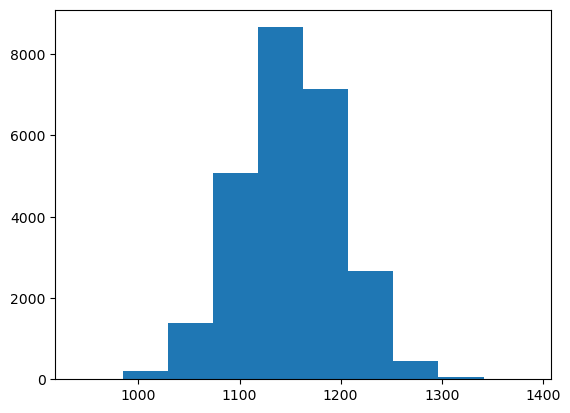

In [325]:
plt.hist(lengths)

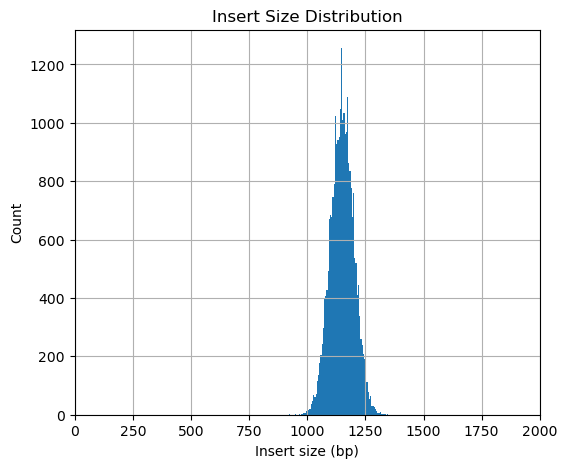

In [326]:
# sanity check on outer distance shape
lengths = [r - l for read in cm.reads['cell1']['results'][0] for _, l, r, _ in [read]]
# lengths += [r - l for read in cm.reads['cell1']['suspects'][0] for _, l, r, _ in [read]]
# Filter out extreme values for better visualization
filtered_lengths = [x for x in lengths if abs(x) < cm.d["outerdist"] * 2]  # Adjust cutoff as needed


plt.figure(figsize=(6, 5))
plt.xlim([cm.d["outerdist"] - 1000, cm.d["outerdist"] + 1000])
plt.hist(filtered_lengths, bins=500)
plt.title("Insert Size Distribution")
plt.xlabel("Insert size (bp)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [327]:
cm.cells['cell1'].mut

{'copynum': 2,
 'allele': 0,
 'region_loc_': 1500,
 'region_len_': 500,
 'tr_': ([1995, 1996, 1997, 1998, 1999], [1500, 1501, 1502, 1503, 1504], 2)}

In [328]:
cm.density_sufficient_muts

[('cell1', np.float64(0.0)), ('cell2', np.float64(10.0))]

In [329]:
cm.density_sufficient_muts

[('cell1', np.float64(0.0)), ('cell2', np.float64(10.0))]

In [330]:
len(cm.density_sufficient_muts) / cm.num_dbscan_clusters

0.15384615384615385

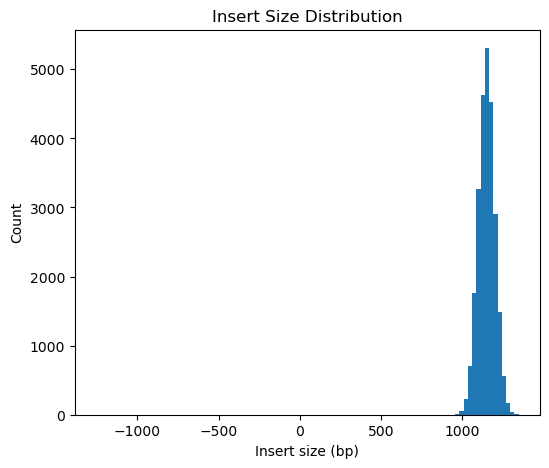

In [331]:
# sanity check on outer distance shape
lengths = [r - l for read in cm.reads['cell1']['results'][0] for _, l, r, _ in [read]]
# lengths += [r - l for read in cm.reads['cell1']['suspects'][0] for _, l, r, _ in [read]]
# Filter out extreme values for better visualization
filtered_lengths = [x for x in lengths if abs(x) < 5000]  # Adjust cutoff as needed

plt.figure(figsize=(6, 5))
plt.hist(filtered_lengths, bins=100)
plt.title("Insert Size Distribution")
plt.xlabel("Insert size (bp)")
plt.ylabel("Count")
plt.show()

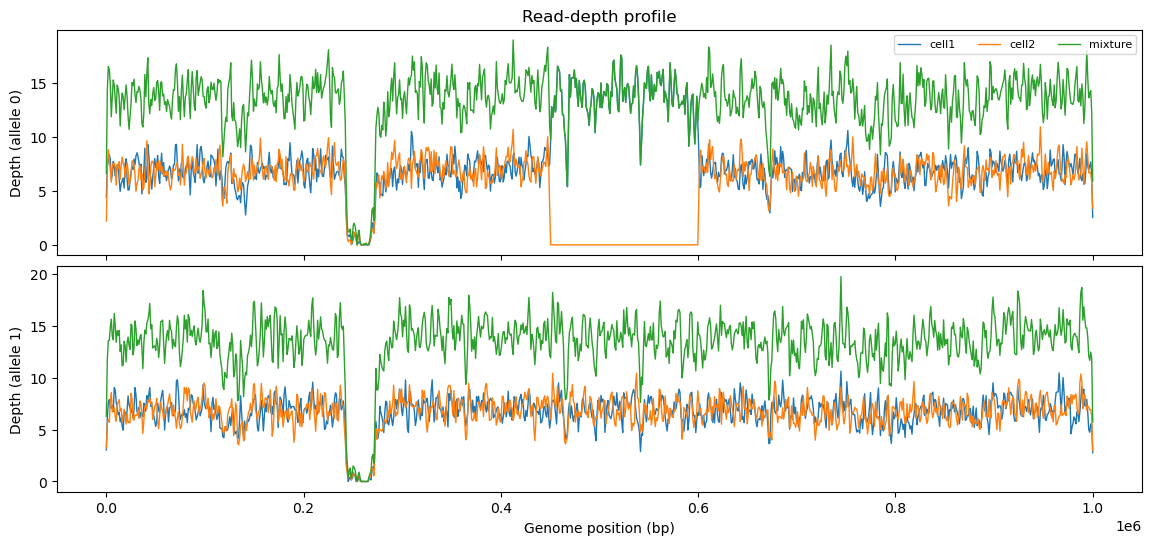

In [332]:
cm.visualize_coverage(saveas = "/Users/rfeld/Documents/Research/SPATIAL/pipeline/perfectindel.svg")

In [333]:
for cell in cm.d["cell_names"]:
    m = cm.cells[cell].mut
    print(cell, m)
    true_left = m['tr_'][0][-1] * cm.d['resolution']
    true_right = m['tr_'][1][0] * cm.d['resolution'] 
    print(f"real indices: {m['tr_'][0][-1] * cm.d['resolution']}, {m['tr_'][1][0] * cm.d['resolution']}")

m_copynum = m['copynum']

cell2 {'copynum': 0, 'allele': 0, 'region_loc_': 1500, 'region_len_': 1000, 'tr_': ([1495, 1496, 1497, 1498, 1499], [2000, 2001, 2002, 2003, 2004], 0)}
real indices: 449700, 600000
cell1 {'copynum': 2, 'allele': 0, 'region_loc_': 1500, 'region_len_': 500, 'tr_': ([1995, 1996, 1997, 1998, 1999], [1500, 1501, 1502, 1503, 1504], 2)}
real indices: 599700, 450000


In [334]:
# cell1 = pysam.FastaFile(cm.fasta_locs['cell1'][0])
# region_start = true_left
# region_end = true_left + 100 
# region_len = 500 * cm.d["resolution"]

# ref_seq = cell1.fetch("cell1_0", region_start, region_end)
# print(ref_seq)
# ref2_seq = cell1.fetch("cell1_0", region_start + region_len, region_start + region_len + 100)
# print(ref2_seq)

# l0, l1 = region_start + region_len - 50, region_start + region_len - 1
# r0, r1 = region_start + region_len, region_start + region_len + 50

# leftcall = cell1.fetch("cell1_0", l0, l1)
# rightcall = cell1.fetch("cell1_0", r0, r1)

# break_left_right = leftcall + rightcall

# print(break_left_right)

In [335]:
# cm.accumulate_mutations()
# cm.classify_signals()
# print(cm.total_signals, cm.total_true, cm.true_rate)

In [336]:
cm.density_sufficient_muts

[('cell1', np.float64(0.0)), ('cell2', np.float64(10.0))]

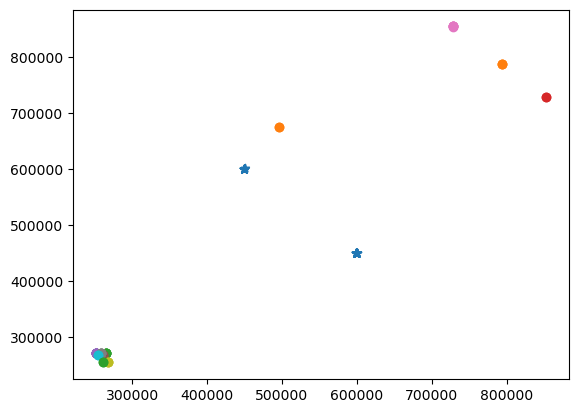

In [337]:
cm.cluster_candidates()

true_vals = [x[1] for x in cm.density_sufficient_muts]
cc = itertools.cycle(cm.palette)
for cluster, color in zip(cm.valid_clusters, cc):
    if cluster in true_vals:
        plt.scatter(cm.valid_clusters[cluster][0][:,0],
                cm.valid_clusters[cluster][0][:,1], color = color, marker = '*')
    else:
        plt.scatter(cm.valid_clusters[cluster][0][:,0],
                    cm.valid_clusters[cluster][0][:,1], color = color)

In [338]:
def cluster_(self):
    cells = ["cell1", "cell2"]
    self.cluster_reads = {c:[] for c in cells}
    for cl in self.valid_clusters:
        arr = self.valid_clusters[cl][0]
        xmin = int(arr[:,0].min())
        ymax = int(arr[:,1].max())

        # call for the read sequences for xmin, ymax 
        xr = (xmin - self.d["insert_max"], xmin + self.d["insert_max"])
        yr = (ymax - self.d["insert_max"], ymax + self.d["insert_max"])

# Define regions around xmin and ymax.
    xr = (xmin - self.d["insert_max"], xmin + self.d["insert_max"])
    yr = (ymax - self.d["insert_max"], ymax + self.d["insert_max"])

    # We always use the actual contig name from the header.
    contig = "chr21_tiny"

    for c in cells:
        for i in range(2):
            left_matches = []
            right_matches = []
            unsorted_bam_path = f"{self.d['readdir']}/target_{c}_{i}.bam"
            bpath = f"{self.d['readdir']}/target_{c}_{i}_sorted.bam"
            subprocess.check_call([samtools, "sort", unsorted_bam_path, "-o", bpath])
            subprocess.check_call([samtools, "index", bpath])
            bamfile = pysam.AlignmentFile(bpath, "rb")
            if not subprocess.os.path.exists(bpath + ".bai"):
                print("Index file not found, creating index...")
                pysam.index(bpath)
            
            # For the left region, grabbing reads where is_read1 is true.
            for read in bamfile.fetch(contig, xr[0], xr[1]):
                # Remove the filtering if needed for debugging
                if read.is_read1 and not read.is_unmapped:
                    try:
                        mate_read = bamfile.mate(read)
                        # Append a tuple with (read_seq, mate_seq, read.mapq, mate.mapq)
                        left_matches.append((read.query_sequence, mate_read.query_sequence, read.mapq, mate_read.mapq))
                    except Exception as e:
                        # Optionally log the exception.
                        # print(f"Left mate retrieval failed for {read.query_name}: {e}")
                        pass 
            
            # For the right region, grabbing reads where is_read2 is true.
            for read in bamfile.fetch(contig, yr[0], yr[1]):
                if read.is_read2 and not read.is_unmapped:
                    try:
                        mate_read = bamfile.mate(read)
                        right_matches.append((read.query_sequence, mate_read.query_sequence, read.mapq, mate_read.mapq))
                    except Exception as e:
                        # print(f"Right mate retrieval failed for {read.query_name}: {e}")
                        pass 
            
            # Now sort:
            # For left_matches, sort so that the read's mapping quality (index 2) is in descending order
            # and, if there's a tie or difference, the mate's mapping quality (index 3) in ascending order.
            left_matches.sort(key=lambda tup: (-tup[2], tup[3]))
            right_matches.sort(key=lambda tup: (-tup[3], tup[2]))
            
            self.cluster_reads[c].append((cl, left_matches, right_matches))              

 
print(f"true deletion signals: {len(cm.true_reads['cell2'])}")
print(f"true insertion signals: {len(cm.true_reads['cell1'])}")

true deletion signals: 30
true insertion signals: 29


In [339]:
# s = break_left_right
# found_reads = []
# for cell, clusters in cm.cluster_reads.items():
#     for entry in clusters:
#         cluster_label, left_matches, right_matches = entry
#         # For left region: check the mate read sequence – element index 1 of each tuple
#         for match in left_matches:
#             read1_seq, read2_seq, mq1, mq2 = match
#             if read2_seq.lower() in s.lower():
#             # Append cell, cluster label, side marker ("left") and match details
#                 found_reads.append((cell, cluster_label, "left", match))
#         # For right region: check the mate read sequence here as well (because for right region, read is read2 and mate is read1)
#         for match in right_matches:
#             read2_seq, read1_seq, mq2, mq1 = match  # note ordering in our tuple
#             if read1_seq.lower() in s.lower():
#                 found_reads.append((cell, cluster_label, "right", match))

# print("Found the following matching reads:") 
# for rec in found_reads: 
#     cell, cl, side, match = rec 
#     print(f"Cell: {cell}, Cluster: {cl}, Side: {side}, Match tuple: {match}")

In [340]:
def visualize_spatial_2(
            self,
            *,
            density=None, 
                     savefig = "",         # None → old scatter only
                                # "hex" → hexbin    • fastest
                                # "hist"→ 2-d hist • pixel heat-map
                                # "kde" → smoothed kernel density
            gridsize=120,          # hexbin / hist resolution
            cmap="inferno",        # colormap for the density layer
    ):
        """Scatter plot of (left bp , right bp) with optional density heat-map.

        Parameters
        ----------
        density : {"hex","hist","kde",None}
            Type of heat-map to draw behind the per-cell points.
        gridsize : int
            Bin count per axis (hex / hist) or mesh size (kde).
        cmap : str
            Matplotlib colormap for the heat-map.
        """
        # ------------------------------------------------ colours per cell
        mix_cells = list(self.d["mixture_props"].keys())
        n_cells   = len(mix_cells)
        cmap_cells = (plt.get_cmap("tab10") if n_cells <= 10 else
                    plt.get_cmap("tab20") if n_cells <= 20 else
                    plt.get_cmap("hsv"))
        colors = [cmap_cells(i) for i in range(n_cells)]



        # ------------------------------------------------ optional density layer
        if density:
            # gather *all* signal reads into one big 2-col array
            sig_arrays = [np.asarray([(x[1], x[2]) for x in self.signal_reads[c]])
                        for c in mix_cells]
            sig_arrays = [a for a in sig_arrays if a.size]           # drop empties
            if sig_arrays:
                SIG = np.vstack(sig_arrays)   # (N,2)
                X, Y = SIG[:, 0], SIG[:, 1]

                # mask = X >= 300_000
                # X = X[mask]
                # Y = Y[mask]

                if density == "hex":                 # ――――― Hex-bin ―――――
                    plt.hexbin(X, Y, gridsize=gridsize,
                            bins="log", cmap=cmap, alpha=0.7,
                            mincnt=1)

                elif density == "hist":              # ―――― 2-D hist ――――
                    H, xe, ye = np.histogram2d(X, Y, bins=gridsize)
                    plt.imshow(H.T, origin="lower", cmap=cmap,
                            extent=[xe[0], xe[-1], ye[0], ye[-1]],
                            aspect="auto", alpha=0.7)

                elif density == "kde":               # ―――― KDE ――――――――
                    kde = gaussian_kde(SIG.T)
                    xmin, xmax = X.min(), X.max()
                    ymin, ymax = Y.min(), Y.max()
                    xi = np.linspace(xmin, xmax, gridsize)
                    yi = np.linspace(ymin, ymax, gridsize)
                    xi, yi = np.meshgrid(xi, yi)
                    zi = kde(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
                    plt.pcolormesh(xi, yi, zi, shading="auto",
                                cmap=cmap, alpha=0.7)

                plt.colorbar(label="density")

        # ------------------------------------------------ per-cell scatter
        for color, cell in zip(colors, mix_cells):
            c_sig = np.asarray(
                    [(x[1], x[2]) for x in self.signal_reads[cell]])
            ct_sig = np.asarray(
                    [(x[1], x[2]) for x in self.true_reads[cell]])

            if c_sig.ndim == 2 and c_sig.size:
                plt.scatter(c_sig[:, 0], c_sig[:, 1],
                            s=18, color=color, alpha=0.2, label=cell)

            if ct_sig.ndim == 2 and ct_sig.size:
                plt.scatter(ct_sig[:, 0], ct_sig[:, 1],
                            s=60, marker="*", color=color,
                            edgecolor="k", label=f"true {cell}")

        # ------------------------------------------------ figure cosmetics
        plt.xlabel("left read (bp)")
        plt.ylabel("right read (bp)")
        plt.title("Spatial Clustering of Signal Islands")
        plt.legend(ncol=2, fontsize=8)
        plt.tight_layout()

        if savefig:
            plt.savefig(savefig)
        plt.show()


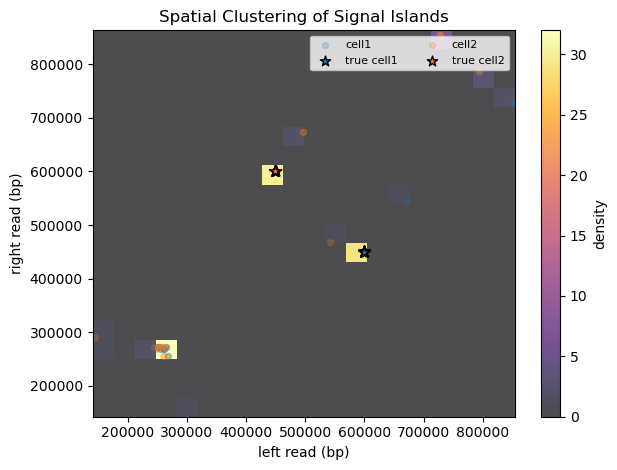

In [341]:
visualize_spatial_2(cm, density = "hist", gridsize = 20, savefig = '/Users/rfeld/Documents/Research/SPATIAL/pipeline/perfectindel_cluster.svg')

In [342]:
visualize_spatial(cm, density = "hist", gridsize = 20)

NameError: name 'visualize_spatial' is not defined